In [2]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

<IPython.core.display.Javascript object>


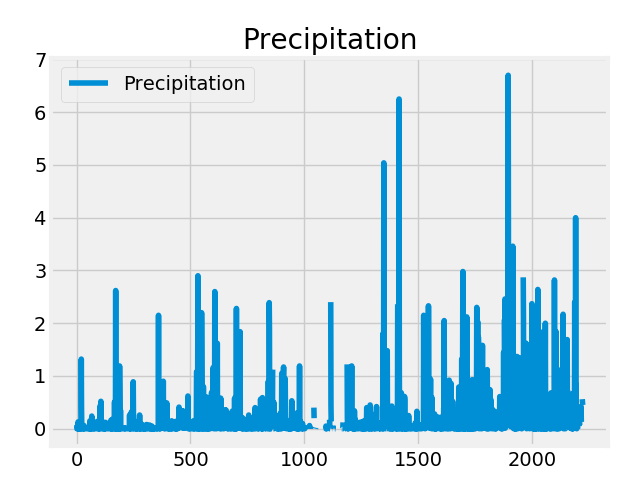

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_entry=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_365_days=dt.date(2017,8,23) - dt.timedelta(days=365)

# Calculate the date 1 year ago from today
year_ago = dt.date.today() - dt.timedelta(days=365) 

# Perform a query to retrieve the data and precipitation scores
date_and_prcp=session.query(Measurement.date, Measurement. prcp).filter(Measurement.date > '2016-08-23').all()
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df=pd.DataFrame(date_and_prcp, columns=['Date','Precipitation'])
prcp_df.set_index('Date')
# Sort the dataframe by date
prcp_df.head()
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(title="Precipitation")
# Rotate the xticks for the dates
tick_locations = np.arange(len(prcp_df))
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# How many stations are available in this dataset?
session.query(Station.id).count()


9

In [17]:
# What are the most active stations?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.id)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
sel = [ 
       func.max(Measurement.tobs), 
       func.min(Measurement.tobs), 
       func.avg(Measurement.tobs)]
most_active_station = session.query(*sel).\
    filter(Measurement.station == 'USC00519281')\
    .all()
most_active_station

[(85.0, 54.0, 71.66378066378067)]

<IPython.core.display.Javascript object>


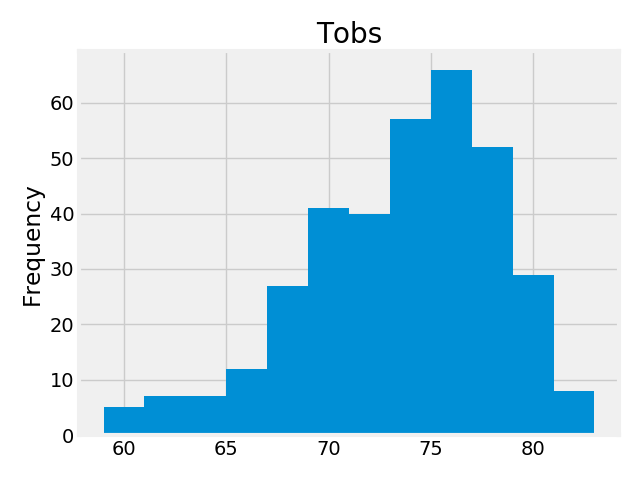

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_plot=session.query(Measurement.tobs).\
filter(Measurement.date > '2016-08-23', Measurement.station == 'USC00519281').all()

most_active_plot_df=pd.DataFrame(most_active_plot, columns=['Tobs'])
grouped=most_active_plot_df['Tobs'].value_counts()
grouped_df=pd.DataFrame({'Frequency':grouped})
sorted_df=grouped_df.sort_index()

most_active_plot_df.hist(bins = 12)
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [20]:
from flask import Flask, jsonify

In [21]:
app = Flask(__name__)

#Query for the dates and temperature observations from the last year.
date_and_tobs=session.query(Measurement.date, Measurement.tobs).filter(Measurement.date > '2016-08-23').all()

#Convert the query results to a Dictionary using date as the key and tobs as the value.
date_and_tobs_df=pd.DataFrame(date_and_tobs, columns=['Date','Tobs'])
date_and_tobs_dict=date_and_tobs_df.to_dict()

#Return the JSON representation of your dictionary.
@app.route("/api/v1.0/precipitation")
def precipitation():
    "Query of Date and Tobs"
    return jsonify(date_and_tobs_dict)

In [22]:
#Return a JSON list of stations from the dataset.
station_query=session.query(Station.id, Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation).all()
station_query_df=pd.DataFrame(station_query, columns=['ID','Station','Name','Latitude','Longitude','Elevation'])
station_query_dict=station_query_df.to_dict()

@app.route("/api/v1.0/stations")
def stations():
    "Query of Stations"
    return jsonify(station_query_dict)


In [23]:
#Return a JSON list of Temperature Observations (tobs) for the previous year.
#Return a JSON list of Temperature Observations (tobs) for the previous year.
query_tobs=session.query(Measurement.tobs).filter(Measurement.date > '2016-08-23').all()

#Convert the query results to a Dictionary using date as the key and tobs as the value.
query_tobs_df=pd.DataFrame(query_tobs, columns=['Tobs'])
tobs_dict=query_tobs_df.to_dict()

#Return the JSON representation of your dictionary.
@app.route("/api/v1.0/tobs")
def tobs():
    "Query of Tobs"
    return jsonify(tobs_dict)

In [24]:
#Return a JSON list of the minimum temperature, the average temperature, and the max temperature for a given start or start-end range.
#When given the start only, calculate TMIN, TAVG, and TMAX for all dates greater than and equal to the start date.

@app.route("/api/v1.0/2016-08-23")
def start_only():
    "Query of Start Date Only, Min Temperature, Avg Temperature, Max Temperature"
    return tmin.query_tobs, tavg.query_tobs, tmax.query_tobs


In [25]:
#When given the start and the end date, calculate the TMIN, TAVG, and TMAX for dates between the start and end date inclusive.

query_start_and_end=session.query(Measurement.tobs).filter(Measurement.date >= '2016-09-23', Measurement.date >= '2016-10-23').all()
@app.route("/api/v1.0/2016-09-23/2016-10-23")
def date_range():
    "Query of Data between Start and End Date, Min Temperature, Avg Temperature, Max Temperature"
    return tmin.query_start_and_end, tavg.query_start_and_end, tmax.query_start_and_end